<a href="https://colab.research.google.com/github/pzwiernik/22997-networks/blob/main/colabs/NetworkNotebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Spreading Phenomena – Colab Notebook

This notebook accompanies the lecture on spreading phenomena and epidemics on networks.

It has four goals:

1. Refresh the continuous-time SI, SIS, and SIR models and show how to simulate their solutions numerically.
2. Implement the SI model on networks and compare the epidemic curves on different graph topologies.
3. Do the same for SIR on networks.
4. Simulate rumor spreading (Maki–Thompson model) on networks and compare it to SIR.

Notation is kept consistent with the lecture:

- Continuous time:
  - contact rate: c
  - infection rate: β
  - recovery rate: μ
  - fractions: s(t), i(t), r(t) for susceptible, infected, recovered
- Discrete time on networks:
  - infection probability per time step along an edge: p
  - recovery probability per time step: r

You are encouraged to play with the parameters and network types and see how the curves change.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    !pip install networkx
    import networkx as nx

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

rng = np.random.default_rng(123)



## 1. Continuous-time SI, SIS, and SIR models

We consider a large population of size N and work with fractions

s(t) = S(t)/N,  i(t) = I(t)/N,  r(t) = R(t)/N,

so that s(t) + i(t) + r(t) = 1.

Under homogeneous mixing, each individual has the same chance of meeting anyone else, and:

- c = average number of contacts per individual per unit time,
- β = probability of infection per contact and per unit time,
- μ = recovery rate (per unit time).

For a small time interval Δt, we model:
- infection given an I–S contact as having probability β Δt + o(Δt),
- recovery of an infected individual during Δt as having probability μ Δt + o(Δt).

This leads to the standard differential equations.


In [2]:

def rhs_SI(t, i, beta, c):
    # SI model in terms of fraction infected i(t): di/dt = beta * c * i * (1 - i)
    return beta * c * i * (1 - i)

def rhs_SIS(t, i, beta, c, mu):
    # SIS model: di/dt = beta * c * i * (1 - i) - mu * i
    return beta * c * i * (1 - i) - mu * i

def rhs_SIR(t, y, beta, c, mu):
    # SIR model in fractions: y = (s, i, r)
    s, i, r = y
    ds = - beta * c * s * i
    di =   beta * c * s * i - mu * i
    dr =   mu * i
    return np.array([ds, di, dr])

def euler_ode_1d(rhs, t_span, y0, n_steps, *params):
    t0, T = t_span
    t = np.linspace(t0, T, n_steps + 1)
    dt = (T - t0) / n_steps
    y = np.empty_like(t)
    y[0] = y0
    for k in range(n_steps):
        y[k+1] = y[k] + dt * rhs(t[k], y[k], *params)
        y[k+1] = max(0.0, min(1.0, y[k+1]))
    return t, y

def euler_ode_3d(rhs, t_span, y0, n_steps, *params):
    t0, T = t_span
    t = np.linspace(t0, T, n_steps + 1)
    dt = (T - t0) / n_steps
    y = np.zeros((n_steps + 1, 3))
    y[0] = np.array(y0)
    for k in range(n_steps):
        y[k+1] = y[k] + dt * rhs(t[k], y[k], *params)
        y[k+1] = np.clip(y[k+1], 0.0, 1.0)
        s, i, r = y[k+1]
        total = s + i + r
        if total > 0:
            y[k+1] /= total
    return t, y



### 1.1 Simulating the SI model

The SI model in fractions is

di/dt = β c i(t) (1 - i(t)),

with initial condition i(0) = i0.

For small i0, the early growth is approximately exponential:

i(t) ≈ i0 e^{β c t}.

Below we simulate SI for given parameters using the Euler method.
You can change beta, c, i0, T, or n_steps and re-run.


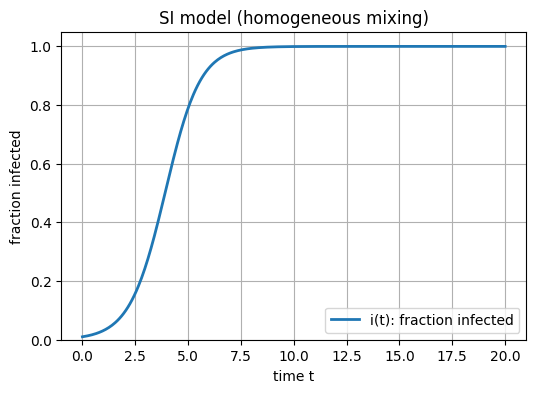

Final fraction infected i(T) ≈ 1.0000


In [3]:

beta = 0.4
c    = 3.0
i0   = 0.01
T    = 20.0
n_steps = 400

t, i = euler_ode_1d(rhs_SI, (0.0, T), i0, n_steps, beta, c)

plt.figure()
plt.plot(t, i, lw=2, label="i(t): fraction infected")
plt.xlabel("time t")
plt.ylabel("fraction infected")
plt.ylim(0, 1.05)
plt.title("SI model (homogeneous mixing)")
plt.legend()
plt.show()

print(f"Final fraction infected i(T) ≈ {i[-1]:.4f}")



### 1.2 Simulating the SIS model

The SIS model in fractions is

di/dt = β c i(t) (1 - i(t)) - μ i(t)
      = (β c - μ) i(t) - β c i(t)^2.

- If β c > μ: endemic regime with equilibrium i* = 1 - μ / (β c) in (0, 1).
- If β c ≤ μ: disease-free regime, the only equilibrium in [0,1] is i = 0.

We simulate numerically.


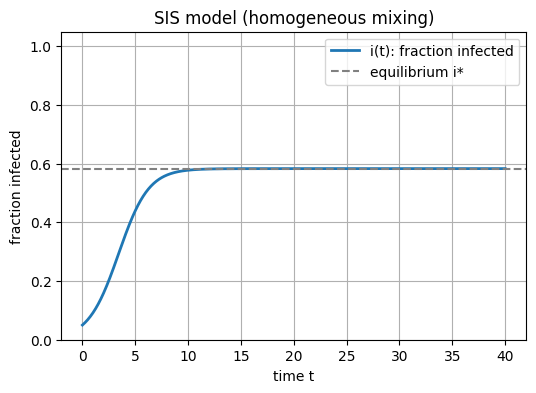

Equilibrium i* (if beta*c > mu) = 0.5833
Numerical i(T) ≈ 0.5833


In [4]:

beta = 0.4
c    = 3.0
mu   = 0.5
i0   = 0.05
T    = 40.0
n_steps = 800

t, i = euler_ode_1d(rhs_SIS, (0.0, T), i0, n_steps, beta, c, mu)
i_star = max(0.0, 1.0 - mu/(beta*c))

plt.figure()
plt.plot(t, i, lw=2, label="i(t): fraction infected")
plt.axhline(i_star, ls="--", color="gray", label="equilibrium i*")
plt.xlabel("time t")
plt.ylabel("fraction infected")
plt.ylim(0, 1.05)
plt.title("SIS model (homogeneous mixing)")
plt.legend()
plt.show()

print(f"Equilibrium i* (if beta*c > mu) = {i_star:.4f}")
print(f"Numerical i(T) ≈ {i[-1]:.4f}")



### 1.3 Simulating the SIR model

The SIR system:

ds/dt = - β c s(t) i(t)
di/dt = β c s(t) i(t) - μ i(t)
dr/dt = μ i(t),

with s(t) + i(t) + r(t) = 1.

- i(t) grows initially when β c s(t) > μ.
- The epidemic peaks when s(t) = μ / (β c).
- Eventually i(t) decreases to 0; only s(∞) and r(∞) remain.

We simulate SIR and plot s(t), i(t), r(t).


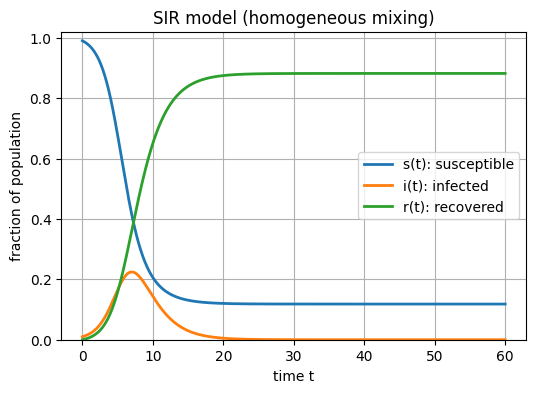

Final susceptible fraction s(T) ≈ 0.1181
Final recovered fraction  r(T) ≈ 0.8819


In [5]:

beta = 0.4
c    = 3.0
mu   = 0.5
i0   = 0.01
s0   = 1.0 - i0
r0   = 0.0
T    = 60.0
n_steps = 1200

t, y = euler_ode_3d(rhs_SIR, (0.0, T), (s0, i0, r0), n_steps, beta, c, mu)
s, i, r = y[:,0], y[:,1], y[:,2]

plt.figure()
plt.plot(t, s, label="s(t): susceptible", lw=2)
plt.plot(t, i, label="i(t): infected",   lw=2)
plt.plot(t, r, label="r(t): recovered",  lw=2)
plt.xlabel("time t")
plt.ylabel("fraction of population")
plt.ylim(0, 1.02)
plt.title("SIR model (homogeneous mixing)")
plt.legend()
plt.show()

print(f"Final susceptible fraction s(T) ≈ {s[-1]:.4f}")
print(f"Final recovered fraction  r(T) ≈ {r[-1]:.4f}")



## 2. SI model on networks

Now consider discrete time dynamics on a fixed network G:

- Nodes = individuals.
- Edges = possible contacts.
- Each node is S (susceptible) or I (infected).
- Time steps: t = 0, 1, 2, …
- At each step, for every edge (I, S), infection is transmitted with probability p.
- Once infected, a node never recovers (SI).

We track the fraction of infected nodes over time:

i_t = (# infected nodes at time t) / |V(G)|.

We will compare i_t on different graphs:

- a line (chain) graph,
- a tree,
- an Erdős–Rényi random graph,
- a scale-free network (Barabási–Albert).


In [6]:

def simulate_SI_network(G, p, initially_infected=None, T=20, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    nodes = list(G.nodes())
    n = len(nodes)
    infected = set()

    if initially_infected is None:
        infected.add(rng.choice(nodes))
    else:
        infected.update(initially_infected)

    frac_infected = np.zeros(T+1)
    frac_infected[0] = len(infected) / n

    for t in range(1, T+1):
        new_infected = set()
        for u in infected:
            for v in G.neighbors(u):
                if v not in infected:
                    if rng.random() < p:
                        new_infected.add(v)
        infected |= new_infected
        frac_infected[t] = len(infected) / n
        if len(infected) == n:
            frac_infected[t:] = 1.0
            break

    return frac_infected


In [7]:

def make_chain_graph(n):
    return nx.path_graph(n)

def make_tree_graph(k, h):
    return nx.balanced_tree(r=k, h=h)

def make_er_graph(n, p_edge, rng=None):
    return nx.erdos_renyi_graph(n, p_edge, seed=rng)

def make_scale_free_graph(n, m=2, rng=None):
    return nx.barabasi_albert_graph(n, m, seed=rng)



### 2.1 Comparing SI on different networks

We simulate SI on:

- a chain with 200 nodes,
- a balanced 3-ary tree,
- an Erdős–Rényi graph with edge probability 0.03,
- a scale-free network.

We start from a single infected node and use the same infection probability p on all networks.


Number of nodes in all graphs: 364


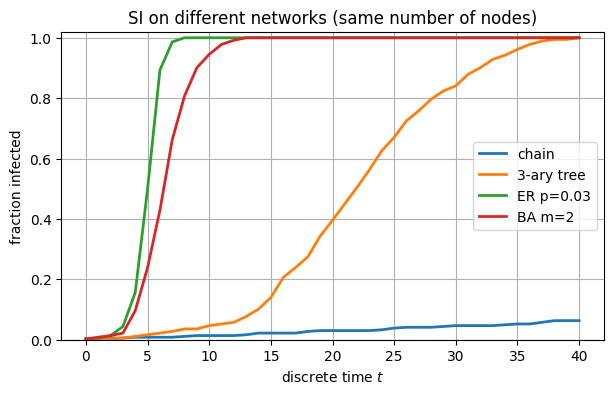

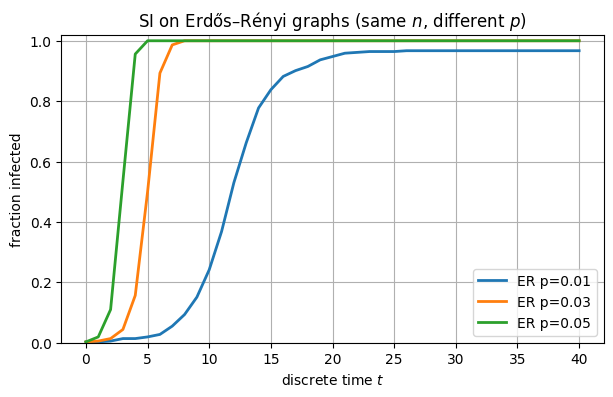

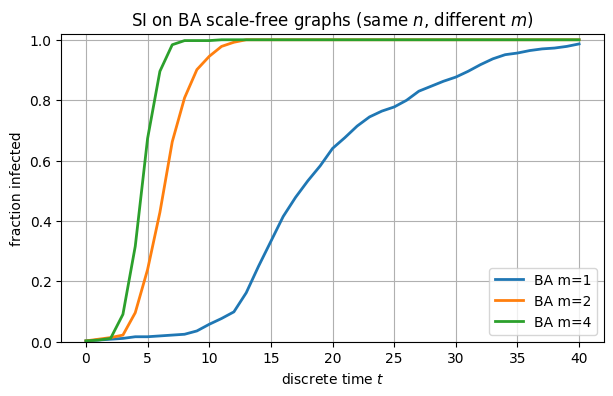

In [12]:
p = 0.3          # infection probability per contact per step
T = 40           # number of discrete time steps
rng = np.random.default_rng(42)

# --- 1. Build the 3-ary tree and use its size as reference ---
G_tree = make_tree_graph(k=3, h=5)   # balanced 3-ary tree
n_nodes = G_tree.number_of_nodes()
print("Number of nodes in all graphs:", n_nodes)

# --- 2. Build all other graphs with exactly the same number of nodes ---
G_chain = make_chain_graph(n_nodes)

# baseline ER and BA
G_er      = make_er_graph(n=n_nodes, p_edge=0.03, rng=42)
G_sf      = make_scale_free_graph(n=n_nodes, m=2, rng=42)

# extra ER variants: sparser / denser
G_er_sparse = make_er_graph(n=n_nodes, p_edge=0.01, rng=123)
G_er_dense  = make_er_graph(n=n_nodes, p_edge=0.05, rng=456)

# extra BA variants: different m (avg degree)
G_sf_m1 = make_scale_free_graph(n=n_nodes, m=1, rng=101)
G_sf_m4 = make_scale_free_graph(n=n_nodes, m=4, rng=202)

# --- 3. Run SI simulations on all graphs ---
frac_chain = simulate_SI_network(G_chain, p, T=T, rng=rng)
frac_tree  = simulate_SI_network(G_tree,  p, T=T, rng=rng)
frac_er    = simulate_SI_network(G_er,    p, T=T, rng=rng)
frac_sf    = simulate_SI_network(G_sf,    p, T=T, rng=rng)

frac_er_sparse = simulate_SI_network(G_er_sparse, p, T=T, rng=rng)
frac_er_dense  = simulate_SI_network(G_er_dense,  p, T=T, rng=rng)

frac_sf_m1 = simulate_SI_network(G_sf_m1, p, T=T, rng=rng)
frac_sf_m4 = simulate_SI_network(G_sf_m4, p, T=T, rng=rng)

t_vals = np.arange(T + 1)

# --- 4. Figure 1: different topologies, same n ---
plt.figure(figsize=(7, 4))
plt.plot(t_vals, frac_chain, label="chain", lw=2)
plt.plot(t_vals, frac_tree,  label="3-ary tree", lw=2)
plt.plot(t_vals, frac_er,    label="ER p=0.03", lw=2)
plt.plot(t_vals, frac_sf,    label="BA m=2", lw=2)
plt.xlabel("discrete time $t$")
plt.ylabel("fraction infected")
plt.ylim(0, 1.02)
plt.title("SI on different networks (same number of nodes)")
plt.legend()
plt.show()

# --- 5. Figure 2: ER graphs with different edge probabilities ---
plt.figure(figsize=(7, 4))
plt.plot(t_vals, frac_er_sparse, label="ER p=0.01", lw=2)
plt.plot(t_vals, frac_er,        label="ER p=0.03", lw=2)
plt.plot(t_vals, frac_er_dense,  label="ER p=0.05", lw=2)
plt.xlabel("discrete time $t$")
plt.ylabel("fraction infected")
plt.ylim(0, 1.02)
plt.title("SI on Erdős–Rényi graphs (same $n$, different $p$)")
plt.legend()
plt.show()

# --- 6. Figure 3: scale-free (BA) graphs with different m ---
plt.figure(figsize=(7, 4))
plt.plot(t_vals, frac_sf_m1, label="BA m=1", lw=2)
plt.plot(t_vals, frac_sf,    label="BA m=2", lw=2)
plt.plot(t_vals, frac_sf_m4, label="BA m=4", lw=2)
plt.xlabel("discrete time $t$")
plt.ylabel("fraction infected")
plt.ylim(0, 1.02)
plt.title("SI on BA scale-free graphs (same $n$, different $m$)")
plt.legend()
plt.show()


Comments.

- On the chain, the infection front moves roughly linearly in time.
- On the tree, infection can fan out along many branches.
- On an Erdős–Rényi graph, the curve often looks logistic-shaped.
- On a scale-free network, hubs speed up spreading: once infected, they infect many neighbours quickly.



## 3. SIR on networks

We now add recovery. In discrete time:

- States: S, I, R.
- At each time step:
  - each infected node infects each susceptible neighbour with probability p,
  - each infected node recovers with probability r,
  - recovered nodes stay recovered forever.

We track the fractions of S, I, and R over time.


In [13]:

def simulate_SIR_network(G, p, r, initially_infected=None, T=40, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    nodes = list(G.nodes())
    n = len(nodes)

    S = set(nodes)
    I = set()
    R = set()

    if initially_infected is None:
        v0 = rng.choice(nodes)
        I.add(v0)
        S.remove(v0)
    else:
        for v in initially_infected:
            I.add(v)
            S.remove(v)

    frac_S = np.zeros(T+1)
    frac_I = np.zeros(T+1)
    frac_R = np.zeros(T+1)

    frac_S[0] = len(S) / n
    frac_I[0] = len(I) / n
    frac_R[0] = len(R) / n

    for t in range(1, T+1):
        new_I = set()
        new_R = set()

        for u in I:
            for v in G.neighbors(u):
                if v in S and rng.random() < p:
                    new_I.add(v)

        for u in I:
            if rng.random() < r:
                new_R.add(u)

        S -= new_I
        I |= new_I
        I -= new_R
        R |= new_R

        frac_S[t] = len(S) / n
        frac_I[t] = len(I) / n
        frac_R[t] = len(R) / n

        if len(I) == 0:
            frac_S[t:] = len(S) / n
            frac_I[t:] = 0.0
            frac_R[t:] = len(R) / n
            break

    return frac_S, frac_I, frac_R



### 3.1 SIR on a dense vs sparse network

We simulate SIR on:

- an Erdős–Rényi graph with relatively large edge probability (dense),
- an Erdős–Rényi graph with smaller edge probability (sparse).

We compare the infected curves and the final fraction recovered.


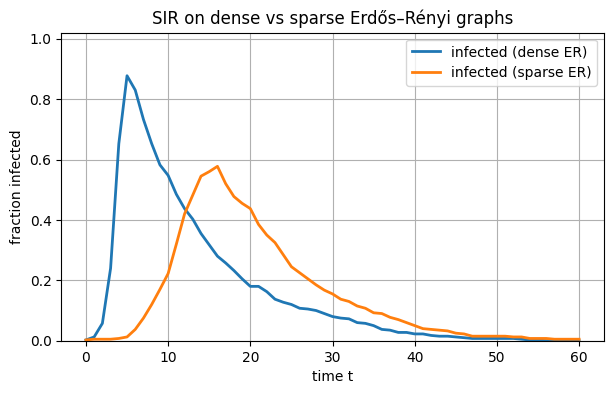

Final recovered fraction dense  ≈ 1.000
Final recovered fraction sparse ≈ 0.938


In [14]:

rng = np.random.default_rng(1)
n = 400

G_dense = make_er_graph(n, p_edge=0.04, rng=1)
G_sparse = make_er_graph(n, p_edge=0.01, rng=2)

p_inf = 0.25
r_rec = 0.1
T = 60

S_d, I_d, R_d = simulate_SIR_network(G_dense,  p_inf, r_rec, T=T, rng=rng)
S_s, I_s, R_s = simulate_SIR_network(G_sparse, p_inf, r_rec, T=T, rng=rng)

t_vals = np.arange(T+1)

plt.figure(figsize=(7,4))
plt.plot(t_vals, I_d, lw=2, label="infected (dense ER)")
plt.plot(t_vals, I_s, lw=2, label="infected (sparse ER)")
plt.xlabel("time t")
plt.ylabel("fraction infected")
plt.ylim(0, 1.02)
plt.title("SIR on dense vs sparse Erdős–Rényi graphs")
plt.legend()
plt.show()

print(f"Final recovered fraction dense  ≈ {R_d[-1]:.3f}")
print(f"Final recovered fraction sparse ≈ {R_s[-1]:.3f}")



Comments.

- On the dense graph, each infected node has many neighbours and the outbreak is large.
- On the sparse graph, the epidemic may die out quickly and the final recovered fraction is smaller.



## 4. Rumor spreading on a network (Maki–Thompson model)

Rumors behave differently from diseases. In the Maki–Thompson model:

- Ignorant (I): has not heard the rumor.
- Spreader (S): knows the rumor and actively tells others.
- Stifler (R): knows the rumor but has lost interest.

At each discrete time step, each spreader chooses one neighbour at random:

- If the neighbour is Ignorant (I), they become a new spreader: I -> S.
- If the neighbour is already Spreader (S) or Stifler (R), the caller loses interest: S -> R.

In contrast to SIR:

- People do not recover automatically after a fixed time.
- They stop spreading only when they realise that others already know the rumor.


In [15]:

def simulate_rumor_MakiThompson(G, initially_spreaders=None, T=40, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    nodes = list(G.nodes())
    n = len(nodes)
    idx = {v: i for i, v in enumerate(nodes)}

    # 0 = I, 1 = S, 2 = R
    state = np.zeros(n, dtype=int)

    if initially_spreaders is None:
        v0 = rng.choice(nodes)
        state[idx[v0]] = 1
    else:
        for v in initially_spreaders:
            state[idx[v]] = 1

    frac_I = np.zeros(T+1)
    frac_S = np.zeros(T+1)
    frac_R = np.zeros(T+1)

    def record(t, state_arr):
        frac_I[t] = np.mean(state_arr == 0)
        frac_S[t] = np.mean(state_arr == 1)
        frac_R[t] = np.mean(state_arr == 2)

    record(0, state)

    for t in range(1, T+1):
        new_state = state.copy()
        spreaders = np.where(state == 1)[0]
        for u_idx in spreaders:
            u = nodes[u_idx]
            neigh = list(G.neighbors(u))
            if not neigh:
                continue
            v = rng.choice(neigh)
            v_idx = idx[v]
            if state[v_idx] == 0:
                new_state[v_idx] = 1
            else:
                new_state[u_idx] = 2
        state = new_state
        record(t, state)
        if np.all((state == 0) | (state == 2)):
            frac_I[t:] = frac_I[t]
            frac_S[t:] = 0.0
            frac_R[t:] = frac_R[t]
            break

    return frac_I, frac_S, frac_R



### 4.1 Rumor spreading on a social network

We simulate the rumor model on a scale-free network (as a crude model of a social network).

We start from one spreader and track the fractions of ignorants, spreaders, and stiflers.


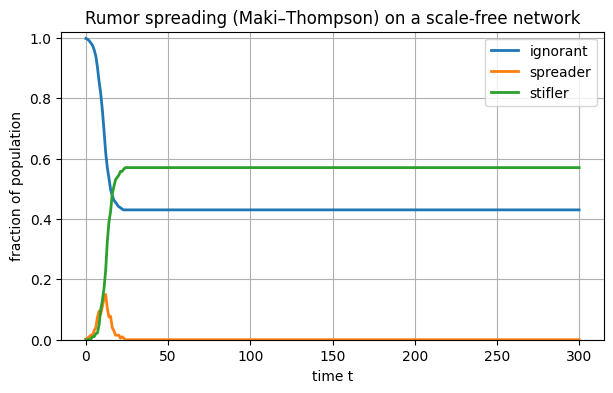

Final ignorant fraction  ≈ 0.430
Final stifler fraction   ≈ 0.570


In [23]:

rng = np.random.default_rng(7)
G_social = make_scale_free_graph(400, m=4, rng=7)

T = 300
frac_I, frac_S, frac_R = simulate_rumor_MakiThompson(G_social, T=T, rng=rng)

t_vals = np.arange(T+1)

plt.figure(figsize=(7,4))
plt.plot(t_vals, frac_I, label="ignorant",  lw=2)
plt.plot(t_vals, frac_S, label="spreader",  lw=2)
plt.plot(t_vals, frac_R, label="stifler",   lw=2)
plt.xlabel("time t")
plt.ylabel("fraction of population")
plt.ylim(0, 1.02)
plt.title("Rumor spreading (Maki–Thompson) on a scale-free network")
plt.legend()
plt.show()

print(f"Final ignorant fraction  ≈ {frac_I[-1]:.3f}")
print(f"Final stifler fraction   ≈ {frac_R[-1]:.3f}")



Comments.

- The number of spreaders rises initially, then falls to zero: in the end, no one is actively spreading the rumor.
- The final fraction of ignorants is often non-zero: the rumor does not necessarily reach everyone.
- In contrast, in SI on a connected network, eventually everyone becomes infected.



## 5. Playground: change parameters and networks

Below is a playground cell where you can:

- Choose a network type,
- Set infection probability p and recovery probability r,
- Run SI, SIR, or rumor simulations.

Feel free to experiment.


Network type: scale_free, nodes: 300, edges: 5600


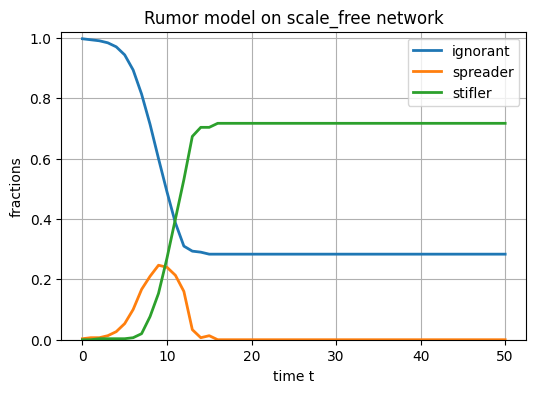

In [32]:

# Example playground for SI, SIR, or rumor on user-chosen network

# Choose model: "SI", "SIR", or "rumor"
model = "rumor"

# Choose network: "chain", "tree", "ER", or "scale_free"
network_type = "scale_free"

n = 300
p_edge = 0.05
k_tree = 8
h_tree = 5
m_sf=20

p_inf = 0.3
r_rec = 0.1
T = 50

rng = np.random.default_rng(123)

if network_type == "chain":
    G = make_chain_graph(n=200)
elif network_type == "tree":
    G = make_tree_graph(k=k_tree, h=h_tree)
elif network_type == "ER":
    G = make_er_graph(n=n, p_edge=p_edge, rng=123)
elif network_type == "scale_free":
    G = make_scale_free_graph(n=n, m=m_sf, rng=123)
else:
    raise ValueError("Unknown network_type")

print(f"Network type: {network_type}, nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

t_vals = np.arange(T+1)

if model == "SI":
    frac_I = simulate_SI_network(G, p_inf, T=T, rng=rng)
    plt.figure()
    plt.plot(t_vals, frac_I, lw=2, label="infected (SI)")
    plt.xlabel("time t")
    plt.ylabel("fraction infected")
    plt.ylim(0, 1.02)
    plt.title(f"SI on {network_type} network")
    plt.legend()
    plt.show()

elif model == "SIR":
    frac_S, frac_I, frac_R = simulate_SIR_network(G, p_inf, r_rec, T=T, rng=rng)
    plt.figure()
    plt.plot(t_vals, frac_S, lw=2, label="S")
    plt.plot(t_vals, frac_I, lw=2, label="I")
    plt.plot(t_vals, frac_R, lw=2, label="R")
    plt.xlabel("time t")
    plt.ylabel("fractions")
    plt.ylim(0, 1.02)
    plt.title(f"SIR on {network_type} network")
    plt.legend()
    plt.show()

elif model == "rumor":
    frac_I, frac_S, frac_R = simulate_rumor_MakiThompson(G, T=T, rng=rng)
    plt.figure()
    plt.plot(t_vals, frac_I, lw=2, label="ignorant")
    plt.plot(t_vals, frac_S, lw=2, label="spreader")
    plt.plot(t_vals, frac_R, lw=2, label="stifler")
    plt.xlabel("time t")
    plt.ylabel("fractions")
    plt.ylim(0, 1.02)
    plt.title(f"Rumor model on {network_type} network")
    plt.legend()
    plt.show()

else:
    raise ValueError("Unknown model")
